In [1]:
# Install required libraries
!pip install -q transformers jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 48.2 MB/s eta 0:00:00


In [2]:
import os
import json
import pickle
from tqdm.notebook import tqdm
from copy import deepcopy
import numpy as np
import random
import heapq

# Data analysis and plotting
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Core ML/AI libraries
import torch
from transformers import WhisperForConditionalGeneration, WhisperProcessor
import jiwer

2025-07-25 19:18:39.074118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753471119.250537      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753471119.309601      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Define the base path for the dataset
BASE_PATH = '/kaggle/input/a1data/'

# Check if the data path exists
if not os.path.exists(BASE_PATH):
    raise FileNotFoundError("Dataset not found. Please add the 'a1data' dataset to the notebook's input.")

# Define full paths
input_file_path = os.path.join(BASE_PATH, 'data.pkl')
phoneme_file_path = os.path.join(BASE_PATH, 'phoneme_table.json')
vocab_file_path = os.path.join(BASE_PATH, 'vocabulary.json')

# Load all data
with open(input_file_path, 'rb') as fp: data = pickle.load(fp)
with open(phoneme_file_path, 'r') as fp: phoneme_table = json.load(fp)
with open(vocab_file_path, 'r') as fp: vocabulary = json.load(fp)

print("Data loaded successfully from /kaggle/input/a1data/")
print(f" - Loaded {len(data)} samples from data.pkl")

# --- Let's explore the loaded data ---

print("\n--- Example of a Data Sample ---")
print(data[0])
print("-" * 30)

print("\n--- Example Phoneme Substitutions ---")
# Display first 5 phoneme rules
for k, v in list(phoneme_table.items())[:5]:
    print(f"'{k}' can be mistaken for: {v}")
print("-" * 30)

print("\n--- Example Vocabulary Words ---")
print(vocabulary[:10])
print("-" * 30)

Data loaded successfully from /kaggle/input/a1data/
 - Loaded 71 samples from data.pkl

--- Example of a Data Sample ---
{'audio': {'array': array([ 0.01193237,  0.00387573, -0.00817871, ...,  0.00112915,
        0.00131226,  0.00143433]), 'sampling_rate': 16000}, 'gold': 'SHE FORMED AMONG THE FLICKERING SHADOWS A GRACEFUL AND HARMONIOUS IMAGE', 'text': 'SHE FOLBED AMONG TE FLICKEWING SHADOWS A GRACEFUL AND HARMONIOUS IMAGE'}
------------------------------

--- Example Phoneme Substitutions ---
'K' can be mistaken for: ['G', 'C']
'S' can be mistaken for: ['Z', 'SH']
'SH' can be mistaken for: ['S', 'CH']
'CH' can be mistaken for: ['SH', 'J']
'TH' can be mistaken for: ['F', 'D', 'T']
------------------------------

--- Example Vocabulary Words ---
["RETURN'D", 'DOCTORS', 'INFANTRY', 'DELIRIUM', 'REFLECT', 'CONSISTENT', 'TWENTIETH', 'LEIRUS', 'MORMONS', 'MANNER']
------------------------------


In [4]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

class CostModel(object):
    def __init__(self) -> None:
        model_name = "openai/whisper-small.en"
        self.__processor = WhisperProcessor.from_pretrained(model_name)
        self.__model = WhisperForConditionalGeneration.from_pretrained(model_name).to(DEVICE)
        self.__audio_inputs = None

    def set_audio(self, audio, sampling_rate):
        self.__audio_inputs = self.__processor(audio, sampling_rate=sampling_rate, return_tensors="pt").input_features.to(DEVICE)

    def get_loss(self, text):
        target = self.__processor(text=text, return_tensors="pt", padding=True).input_ids.to(DEVICE)
        with torch.no_grad():
            outputs = self.__model(input_features=self.__audio_inputs, labels=target)
        return outputs.loss.item()

class Environment(object):
    def __init__(self, init_state, cost_function, phoneme_table) -> None:
        self.init_state = init_state
        self.phoneme_table = deepcopy(phoneme_table)
        self.__cost_function = cost_function

    def compute_cost(self, text):
        try:
            return self.__cost_function(text)
        except:
            return 1e6

class Agent(object):
    def __init__(self, phoneme_table, vocabulary):
        self.phoneme_table = phoneme_table
        self.vocabulary = vocabulary
        self.best_state = None
        
        # Build a reverse map for faster phoneme lookups
        self.reverse_phoneme_table = {}
        for key, values in self.phoneme_table.items():
            for value in values:
                if value not in self.reverse_phoneme_table:
                    self.reverse_phoneme_table[value] = []
                self.reverse_phoneme_table[value].append(key)

    def get_neighbors(self, state):
        """Generates all possible neighbors from a given state."""
        neighbors = set()

        # 1. Add words to front and back
        for word in self.vocabulary:
            neighbors.add(word + " " + state)
            neighbors.add(state + " " + word)
        
        # 2. Substitute phonemes
        for i in range(len(state)):
            # Check for 1-char and 2-char substitutions
            for length in [1, 2]:
                if i + length <= len(state):
                    chunk = state[i:i+length]
                    if chunk in self.reverse_phoneme_table:
                        for replacement in self.reverse_phoneme_table[chunk]:
                            new_state = state[:i] + replacement + state[i+length:]
                            neighbors.add(new_state)
        
        return list(neighbors)

    def asr_corrector(self, environment):
        """ ASR corrector using Beam Search. """
        # Hyperparameters for the search
        BEAM_WIDTH = 5  # How many top candidates to keep at each step
        MAX_STEPS = 5   # How deep the search goes

        initial_cost = environment.compute_cost(environment.init_state)
        beam = [(initial_cost, environment.init_state)]
        visited_states = {environment.init_state: initial_cost}

        for _ in range(MAX_STEPS):
            potential_candidates = []
            
            for _, current_state in beam:
                neighbors = self.get_neighbors(current_state)
                for neighbor in neighbors:
                    if neighbor not in visited_states:
                        cost = environment.compute_cost(neighbor)
                        visited_states[neighbor] = cost
                    heapq.heappush(potential_candidates, (visited_states[neighbor], neighbor))
            
            new_beam_candidates = set()
            while potential_candidates and len(new_beam_candidates) < BEAM_WIDTH:
                cost, state = heapq.heappop(potential_candidates)
                new_beam_candidates.add((cost, state))
            
            if not new_beam_candidates: break
            
            new_beam = sorted(list(new_beam_candidates), key=lambda x: x[0])
            
            if not beam or new_beam[0][0] >= beam[0][0]:
                break
            
            beam = new_beam

        self.best_state = beam[0][1]

Using device: cuda


In [5]:
print("\n--- Starting Main Execution and Evaluation ---")

# Initialize models
print("Initializing Whisper Cost Model... (This may take a moment)")
cost_model = CostModel()
agent = Agent(phoneme_table, vocabulary)
print("Initialization complete.")

# --- Main processing loop with validation ---
results_summary = []

for i, sample in enumerate(tqdm(data, desc="Processing and Validating Samples")):
    audio, sr, initial_text = sample['audio']['array'], sample['audio']['sampling_rate'], sample['text']

    cost_model.set_audio(audio, sr)
    environment = Environment(initial_text, cost_model.get_loss, phoneme_table)
    
    initial_cost = environment.compute_cost(initial_text)

    try:
        agent.asr_corrector(environment)
        predicted_text = agent.best_state
    except Exception as e:
        print(f"An error occurred on sample {i}: {e}")
        predicted_text = initial_text
    
    final_cost = environment.compute_cost(predicted_text)
    
    # Store results for final report
    results_summary.append({
        "id": i,
        "initial_text": initial_text,
        "predicted_text": predicted_text,
        "initial_cost": initial_cost,
        "final_cost": final_cost,
        "cost_change": initial_cost - final_cost  # Positive means improvement
    })

# --- Save final output file ---
corrected_texts_for_submission = [r['predicted_text'] for r in results_summary]
output_file = 'outputs.json'
with open(output_file, 'w') as fp:
    json.dump(corrected_texts_for_submission, fp, indent=2)

print("\nProcessing complete. All results are stored for analysis.")


--- Starting Main Execution and Evaluation ---
Initializing Whisper Cost Model... (This may take a moment)


preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

Initialization complete.


Processing and Validating Samples:   0%|          | 0/71 [00:00<?, ?it/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.



Processing complete. All results are stored for analysis.



--- Cost Improvement Analysis ---
Total Samples Processed: 71
Sentences with Improved Cost: 71 (100.00%)
Sentences with Worsened Cost: 0 (0.00%)
Sentences with Unchanged Cost: 0 (0.00%)
Average Cost Reduction per Sentence: 1.4130
-----------------------------------


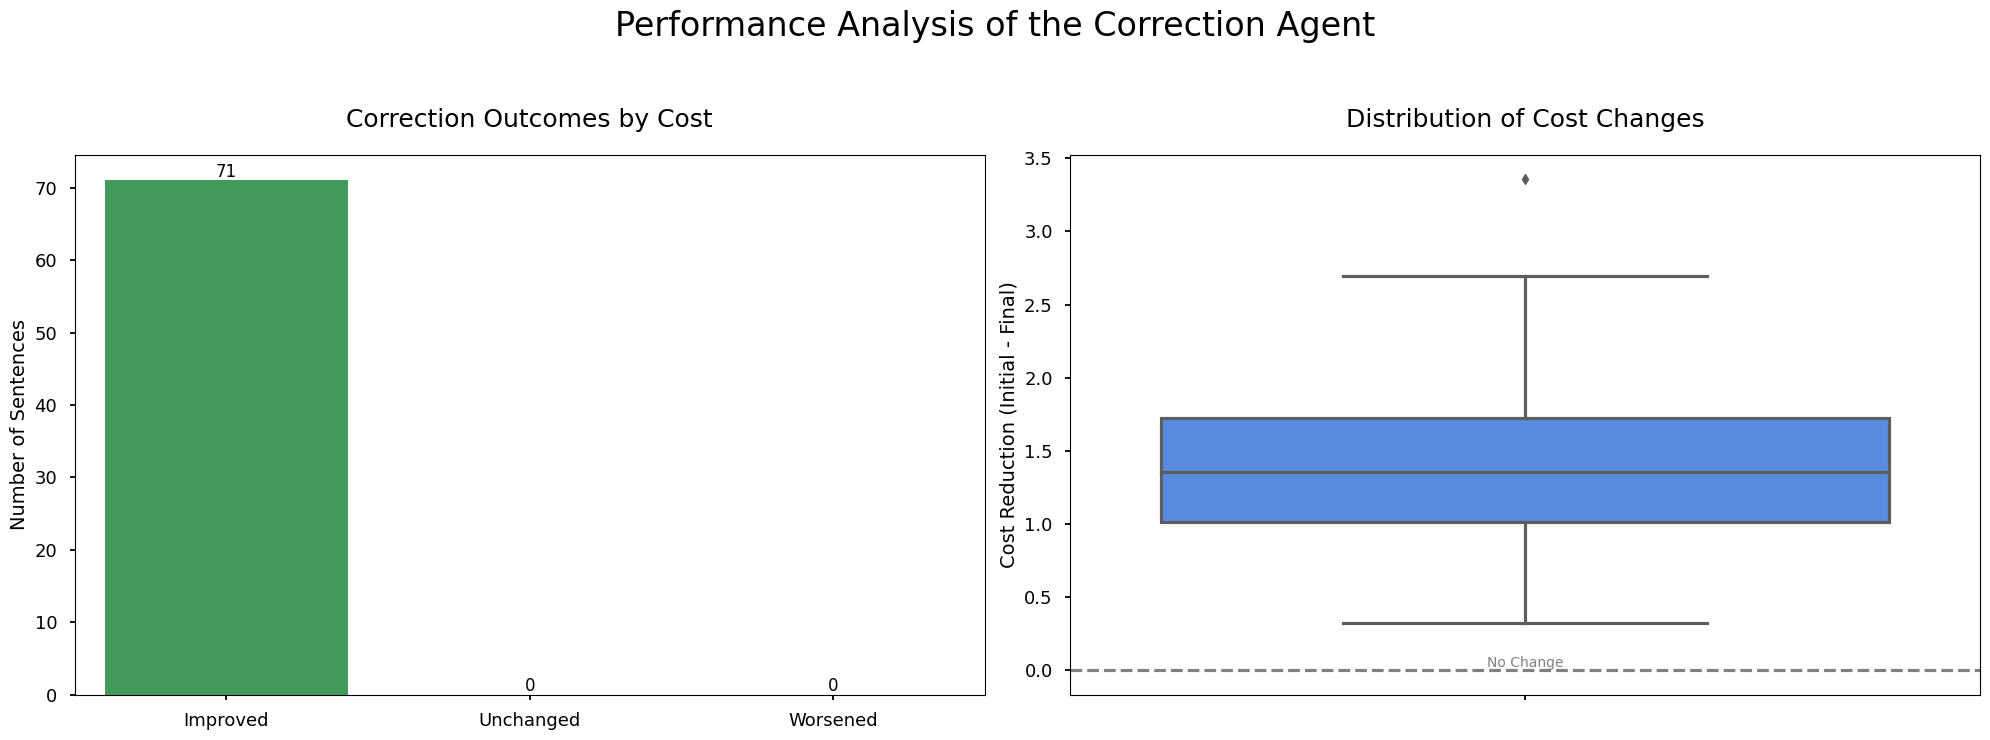


--- Top 5 Best Corrections by Cost Improvement ---


,id,initial_text,predicted_text,initial_cost,final_cost,cost_change
68,68,THE CROWN ALDOUGH FEIR CONCORD HAD ONLY EVIL A...,EXPOSING THE CROWN ALTHOUGH THEIR CONCORD HAD ...,5.180111,1.823429,3.356682
67,67,THEY WERE AND NO HUMAN BEINGSH AT ALL HER,SKELETONS THEY WERE AND NO HUMAN BEINGS AT ALL...,4.279775,1.581918,2.697857
40,40,THE YOUG WOMAN WHEN SE OPENED FE DOOR IN THE M...,THE YOUNG WOMAN WHEN SHE OPENED THE DOOR IN TH...,4.049550,1.611190,2.438360
33,33,ME THEY ZTRIPPED LIKE A SHLAVE FEY LED BE THRO...,ME THEY STRIPPED LIKE A SLAVE THEY LED ME THRO...,3.845333,1.564760,2.280573
61,61,THOUGH THELE'S SHONE ON IT AS ONE'S NO NEED TO...,THOUGH THERE'S SONE ON IT AS ONE'S NO NEED TO ...,4.104392,1.861089,2.243303


In [6]:
# Create a pandas DataFrame for easy analysis
results_df = pd.DataFrame(results_summary)

# --- Quantitative Summary ---
num_improved = (results_df['cost_change'] > 0.001).sum()
num_worsened = (results_df['cost_change'] < -0.001).sum()
num_unchanged = len(results_df) - num_improved - num_worsened
avg_improvement = results_df['cost_change'].mean()

print("\n--- Cost Improvement Analysis ---")
print(f"Total Samples Processed: {len(results_df)}")
print(f"Sentences with Improved Cost: {num_improved} ({num_improved/len(results_df):.2%})")
print(f"Sentences with Worsened Cost: {num_worsened} ({num_worsened/len(results_df):.2%})")
print(f"Sentences with Unchanged Cost: {num_unchanged} ({num_unchanged/len(results_df):.2%})")
print(f"Average Cost Reduction per Sentence: {avg_improvement:.4f}")
print("-----------------------------------")


# --- Visual Analysis ---

plt.style.use('seaborn-v0_8-talk')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# Plot 1: Bar Chart of Outcomes
outcomes = pd.Series({
    'Improved': num_improved,
    'Unchanged': num_unchanged,
    'Worsened': num_worsened
})
sns.barplot(x=outcomes.index, y=outcomes.values, ax=ax1, palette=['#34A853', '#7F8C8D', '#EA4335'])
ax1.set_title('Correction Outcomes by Cost', fontsize=18, pad=20)
ax1.set_ylabel('Number of Sentences', fontsize=14)
for i, val in enumerate(outcomes.values):
    ax1.text(i, val + 0.5, str(val), ha='center', fontsize=12)


# Plot 2: Box Plot of Cost Changes
sns.boxplot(y=results_df['cost_change'], ax=ax2, color='#4285F4')
ax2.set_title('Distribution of Cost Changes', fontsize=18, pad=20)
ax2.set_ylabel('Cost Reduction (Initial - Final)', fontsize=14)
ax2.axhline(0, color='grey', linestyle='--')
ax2.text(0.5, 0, 'No Change', color='grey', ha='center', va='bottom', transform=ax2.get_yaxis_transform())


plt.suptitle('Performance Analysis of the Correction Agent', fontsize=24, y=1.05)
plt.tight_layout()
plt.show()

# --- Display some of the best improvements ---
print("\n--- Top 5 Best Corrections by Cost Improvement ---")
display(results_df.sort_values(by='cost_change', ascending=False).head(5))

In [7]:
# 1. Define ground truth sentences and a "Corruptor" function
ground_truth_sentences = [
    "THE QUICK BROWN FOX JUMPS OVER THE LAZY DOG",
    "A STITCH IN TIME SAVES NINE",
    "THE EARLY BIRD CATCHES THE WORM",
    "ACTIONS SPEAK LOUDER THAN WORDS",
    "BEAUTY IS IN THE EYE OF THE BEHOLDER"
]

def corrupt_sentence(sentence, phoneme_map, vocab):
    corrupted = sentence
    # Corrupt a character
    chars = list(corrupted)
    possible_indices = [i for i, char in enumerate(chars) if char in phoneme_map]
    if possible_indices:
        idx = random.choice(possible_indices)
        chars[idx] = random.choice(phoneme_map[chars[idx]])
        corrupted = "".join(chars)
    # Remove a word
    if random.random() > 0.5:
        words = corrupted.split()
        if len(words) > 1:
            corrupted = " ".join(words[1:])
    return corrupted if corrupted != sentence else sentence.replace('A', 'E', 1)

# 2. Generate and run the validation set
print("\n--- Evaluating agent on a custom-corrupted validation set ---")
dummy_audio_sample = data[0] 
cost_model.set_audio(dummy_audio_sample['audio']['array'], dummy_audio_sample['audio']['sampling_rate'])

custom_results = []
for gt in tqdm(ground_truth_sentences, desc="Creating and Testing Custom Set"):
    corrupted_text = corrupt_sentence(gt, phoneme_table, vocabulary)
    env = Environment(corrupted_text, cost_model.get_loss, phoneme_table)
    agent.asr_corrector(env)
    predicted_text = agent.best_state
    
    metrics = jiwer.compute_measures(gt, predicted_text)
    custom_results.append({
        "Corrupted Text": corrupted_text,
        "Agent's Prediction": predicted_text,
        "Ground Truth": gt,
        "CER": metrics['cer']
    })

# 3. Display results in a clean table
custom_df = pd.DataFrame(custom_results)
avg_cer_before = np.mean([jiwer.compute_measures(r['Ground Truth'], r['Corrupted Text'])['cer'] for r in custom_results])
avg_cer_after = custom_df['CER'].mean()

print("\n--- Accuracy Results (Lower CER is better) ---")
display(custom_df)

print(f"\nAverage Character Error Rate (CER) of Corrupted Text: {avg_cer_before:.2%}")
print(f"Average Character Error Rate (CER) after Agent Correction: {avg_cer_after:.2%}")

cer_improvement = avg_cer_before - avg_cer_after
print(f"Total CER Improvement: {cer_improvement:.2%}")


--- Evaluating agent on a custom-corrupted validation set ---


Creating and Testing Custom Set:   0%|          | 0/5 [00:00<?, ?it/s]

AttributeError: module 'jiwer' has no attribute 'compute_measures'